# SteelMill Column Generation

For this problem, we are solving first the linear relaxation of the SteelMill problem, and then the integer problem.

First, let's recall the problem and the formulation.

This problem aims at producing coils from steel slabs.
Each coil order has a size and a certain color that corresponds to the process needed to produce the coil.

The coils are produced from slabs: there is different sizes for the slabs.
Several orders can be produced from the same slab while the sum of the orders' size does not exceed the slab's size and no more that two colors are used. Let suppose that the stock for each type of slab is unlimited.

The goal is to produce each order while minimizing the total loss (i.e., the size left that is not used in a slab).

Bellow, an exemple of production patterns for few slabs. Each column correspond to a slab, its size and the orders produced.

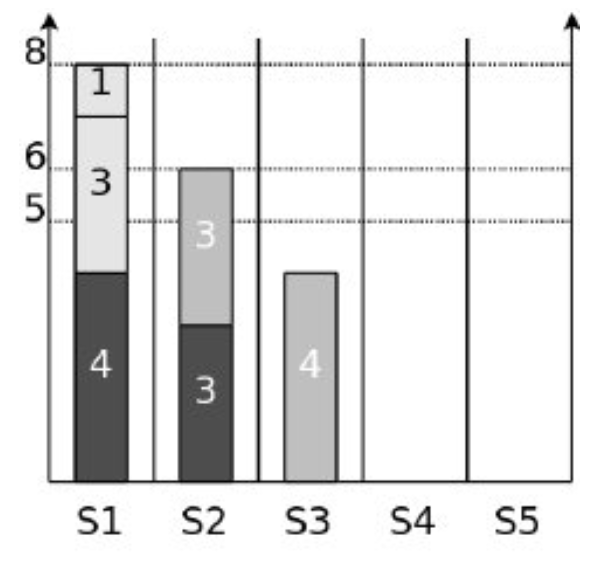

|           |              |
| ----------|:-------------|
| $s_j$ | weight of order $j$  |
| $c_j$ | color of order $j$  |
| $S_k$ | available slab's sizes $k$  |
| $x_{i,j}$ | binary decision, =1 if order $j$ is produced on slab $i$, 0 otherwise  |
| $y_{i,k}$ | binary decision, =1 if size $k$ is used for slab $i$, 0 otherwise  |
| $z_{i,c}$ | binary decision, =1 if color $c$ is present on slab $i$, 0 otherwise  |
| $l_i$ | loss of the slab $i$  |

\begin{align*}
\min & \sum_i l_i & \\
\text{subject to:} && \\
& \sum_i x_{i,j} = 1 & \forall j \\
& \sum_k y_{i,k} = 1 & \forall i \\
& \sum_j s_j * x_{i,j} + l_i = \sum_k S_k * y_{i,k} & \forall i \\
& x_{i,j} \leq z_{i,c_{j}} & \forall i,j \\
& \sum_c z_{i,c} \leq 2  & \forall i \\
& x_{i,j}, y_{i,k}, z_{i,c} \in \mathbb{B} & \forall i,j,k,c \\
& l_i \geq 0 & \forall i
\end{align*}
For the column generation, we will decompose the problem into a master problem, which will be selecting the slabs, and a sub-problem for each slab's size.

The core procedure of the column generation can be described as follow:
1. Create the master problem with some initial columns to have a feasible problem;
2. Solve the linear relaxation of the master problem;
3. Update the sub-problems with the dual variables and solve each of them;
4. For each sub-problem, if the objective is negative, add the corresponding configuration as a new column to the master problem;
5. If any column has been added to the master problem, go to 2, otherwise stop.

Finally, we will create a master problem with all the columns that has been generated by the column generation and we will solve the integer problem. We should normally obtain a good solution of the StellMill problem. The objective value of the column generation is a lower bound that can be used to estimate the quality of the solution found.

Define the inputs:
1. The orders: an order is a tuple (size, color)
2. The sizes

In [11]:
orders = [ (22, 3), (18, 3), (32, 4), (38, 3), (31, 7), (6, 3), (15, 6), (35, 0), (22, 2), (14, 3), (12, 3), (42, 5) ]
sizes = [0, 11, 13, 16, 17, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 40, 43, 45]
colors = list(set(o[1] for o in orders))

nbOrders = len(orders)
nbColors = len(colors)
nbSlabs = len(orders)
nbSizes = len(sizes)

ORDERS = range(nbOrders)
SIZES = range(nbSizes)
SLABS = range(nbOrders)
COLORS = range(nbColors)

maxSlab = max(sizes)

### Exercices

#### 1. Find the formulation of the master and sub-problems.

##### Master:

|           |              |
| ----------|:-------------|
|$l_i$ | loss for slab $j$  |
| $a_{ij}$ | =1 if order $j$ is produced in slab $i$, 0 otherwise |
| $y_i$ | binary decision, =1 if slab $i$ is selected, 0 otherwise  |

\begin{align*}
\min & \sum_i l_i y_i & \\
\text{subject to:} && \\
& \sum_i a_{ij} y_i = 1 & \forall j  \quad (\alpha_j) \\
& y_i \in \mathbb{N} & \forall i
\end{align*}

##### Subproblems:

For a  slab $i$ of size $S_k$ (we drop the index $i$):
\begin{align*}
\min \quad & l - \sum_j \alpha_j x_j & \\
\text{subject to:} && \\
& \sum_j s_j x_j  + l = S_k & \\
& x_j \leq z_{c_j} & \forall j \\
& \sum_c z_c \leq 2 & \\
& y_j, z_c \in \{0,1\} & \forall j,c \\
& l \geq 0 &
\end{align*}

#### 2. Implement the subproblem, and then the master with the column generation logic.

In [12]:
from docplex.mp.model import Model

def subproblem(duals,S):
    pricing = Model(name='steelmill_subproblem_'+str(S))

    x = pricing.binary_var_list(len(orders), name='select')
    z = pricing.binary_var_list(max(colors)+1, name='color')
    l = pricing.integer_var(lb=0, name='loss')

    pricing.add_constraint(sum(orders[j][0] * x[j] for j in ORDERS) + l == S, 'loss')
    for j in ORDERS:
        pricing.add_constraint(x[j] <= z[orders[j][1]], 'color_%d' % j)
    pricing.add_constraint(sum(z) <= 2, 'max_color')
    
    # TODO: modify the objective
    pricing.minimize(l - sum(duals[i] * x[i] for i in ORDERS))
    
    pricing.solve()
    return ([i for i in ORDERS if x[i].solution_value], l.solution_value, pricing.objective_value)

Test the subproblem function:

In [13]:
subproblem([1] * nbOrders,maxSlab)

([1, 6, 10], 0, -3)

### Column Generation
We implement the core logic of the column generation:
1. Create the master problem with some initial columns to have a feasible problem;
2. Solve the linear relaxation of the master problem;
3. Solve the sub-problems with the dual variables;
4. For each sub-problem, if the objective is negative, add the corresponding configuration as a new column to the master problem;
5. If any column has been added to the master problem, go to 2, otherwise stop.

#### Implement the master and solve it with some initial columns (step 1)

In [14]:
master = Model(name='steelmill_master')
# initial fictionnal slabs
slabs = [([i],  # list of produced orders
          maxSlab+1,  # big loss for the slab
          maxSlab+1)  # size of the slab
         for i in ORDERS]
assignment_ctr = [0 for i in ORDERS]
y = master.continuous_var_list(nbSlabs, lb=0, name='select')

for i in ORDERS:
    assignment_ctr = master.add_constraint(sum(y[j] for j in slabs[i][0]) == 1, 'assignment_%d' % i)
dummy_var = master.continuous_var(lb=0, name='dummy')

# big loss as fictionnal we add fictional initial columns
master.minimize((maxSlab+1) * sum(y))

master.solve()
print('objective: %.2f' % master.objective_value)

objective: 552.00


#### Implement the column generation (step 2 - 5)

In [15]:
master = Model(name='steelmill_master')
# initial fictionnal slabs
slabs = [([i],  # list of produced orders
          maxSlab+1,  # big loss for the slab
          maxSlab+1)  # size of the slab
         for i in ORDERS]
assignment_ctr = [0 for i in ORDERS]
y = master.continuous_var_list(nbSlabs, lb=0, name='select')

for i in ORDERS:
    assignment_ctr[i] = master.add_constraint(sum(y[j] for j in slabs[i][0]) == 1, 'assignment_%d' % i)
dummy_var = master.continuous_var(lb=0, name='dummy')

# big loss as fictionnal we add fictional initial columns
master.minimize((maxSlab+1) * sum(y))

precision = 1e-5
iteration = 0

n_new = 0
n_columns = len(slabs)

while True:
   # 2. Solve the linear relaxation of the master problem
    # TODO: solve the linear relaxation of the master problem with the new columns
    
    master.solve()
    print('Iter={:5d}, Master obj={:.2f}, Columns: total={:6d}-- new={:3d}'.format(
        iteration, master.objective_value,len(slabs),n_new))
    print('-------------------------------------------------------------------------------------')
    
    # 3. Solve the sub-problems with the dual variables
    for k in SIZES:
        
        # TODO: solve the sub-problem for the size s
        duals = [assignment_ctr[j].dual_value for j in ORDERS]
        (o, l, obj) = subproblem(duals,sizes[k])
        
        # 4. If the objective is negative, add the the new column to the master problem
        # TODO: add the column of necessary
        if (obj + precision < 0):
            slabs.append((o, l, sizes[k]))
            v = master.continuous_var(lb=0, name='select_%d' % len(slabs));
            y.append(v)
            for j in o:
                assignment_ctr[j].left_expr.add_term(v, 1)
            master.objective_expr.add_term(v, l)
            print('%d. size %2d, loss %2d, configuration %s' % (len(slabs), sizes[k], l, o))
    
    # 5. If any column has been added to the master problem, go to 2, otherwise stop.
    # TODO: stop if column generation has finished
    
    n_new = len(slabs) - n_columns
    n_columns = len(slabs)
    if n_new == 0:
        break

# Print the solution
for s in range(len(slabs)):
    yv = y[s].solution_value
    if yv > 0:
        print('size %2d, loss %2d, orders %s: %.2f' % (slabs[s][2],slabs[s][1],slabs[s][0], yv))

Iter=    0, Master obj=552.00, Columns: total=    12-- new=  0
-------------------------------------------------------------------------------------
13. size 11, loss  5, configuration [5]
14. size 13, loss  1, configuration [10]
15. size 16, loss  1, configuration [6]
16. size 17, loss  2, configuration [6]
17. size 19, loss  1, configuration [5, 10]
18. size 20, loss  0, configuration [5, 9]
19. size 23, loss  2, configuration [5, 6]
20. size 24, loss  0, configuration [1, 5]
21. size 25, loss  1, configuration [1, 5]
22. size 26, loss  0, configuration [9, 10]
23. size 27, loss  0, configuration [6, 10]
24. size 28, loss  0, configuration [0, 5]
25. size 29, loss  0, configuration [6, 9]
26. size 30, loss  0, configuration [1, 10]
27. size 33, loss  0, configuration [5, 6, 10]
28. size 34, loss  1, configuration [5, 6, 10]
29. size 40, loss  0, configuration [0, 5, 10]
30. size 43, loss  0, configuration [0, 5, 6]
31. size 45, loss  0, configuration [1, 6, 10]
Iter=    0, Master obj

### Solve the SteelMill Problem
We use the column generated, to solve the integer problem. So, we must:
1. Redefine a integer problem with all the columns at the beginning;
2. Solve this problem

In [16]:
SLABS = range(len(slabs))

imaster = Model(name='steelmill_master')
y = imaster.binary_var_list(len(slabs), lb=0, name='select')

for i in ORDERS:
    imaster.add_constraint(sum(y[j] for j in SLABS if i in slabs[j][0]) == 1)
imaster.minimize(sum(slabs[i][1] * y[i] for i in SLABS))

imaster.solve()
print('total loss: %d' % imaster.objective_value)
for i in SLABS:
    if y[i].solution_value > 0:
        print('size %2d, loss %2d, orders %s' % (slabs[i][2],slabs[i][1], slabs[i][0]))

total loss: 7
size 45, loss  0, orders [1, 6, 10]
size 45, loss  0, orders [4, 9]
size 33, loss  1, orders [2]
size 40, loss  2, orders [3]
size 43, loss  1, orders [11]
size 43, loss  2, orders [5, 7]
size 45, loss  1, orders [0, 8]
